# Сжатие картинок с помощью SVD разложения
В этом задании нужно сделать сжатие изображения, сжатие с потерями. Для этого мы используем SVD разложение.

Примерный порядок действий:
1) Найти любую картинку,
2) Прочитать её с помощью библиотеки PIL
3) Преобразовать в numpy массив
4) Применить SVD к матрице - обязательно прочитайте справку по этой функции `np.linalg.svd`

**Примечание**: Цветная картинка представляет собой трёхканальное изображение RBG, поэтому напрямую SVD разложение применить не получится. Либо вы преобразуете изображение в одноканальное (градации серого), усредняя все три канала. Либо делаете SVD для всех трёх каналов в отдельности.

5) Далее оставляете небольшое количество сингулярных значений - 1, 2, 10, 30, 100. И выводите результат в виде получившейся картинки - чем больше сингулярных чисел, тем ближе приближённая матрица к исходной.

6) Сравните количество байт, необходимых для хранения исходной картинки и сжатой версии.

Ниже представлены основные функции и библиотеки, которые вам понадобятся.

Задание оформляете в виде блокнота jupyter. Особо понравившиеся картинки можно сохранить отдельно на диск, но мне удобнее чтобы они присутствовали в самом jupyter блокноте.

In [130]:
%pip install Pillow numpy matplotlib pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [131]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import os
import re
import pandas as pd

image_path = "image.png"
img = Image.open(image_path)
w, h = img.size
#img = img.resize((w//4, h//4)) # можно не делать .resize(())

# x = np.array(img, dtype=np.float32) # преобразование из PIL в numpy array
# U, S, V = np.linalg.svd(X, full_matrices=False) # разложение SVD
# # обратное преобразование из numpy array в PIL с сохранение изображения на диск
# Image.fromarray(np.asarray(Y_r, dtype=np.uint8)).save(f'{r}.png')

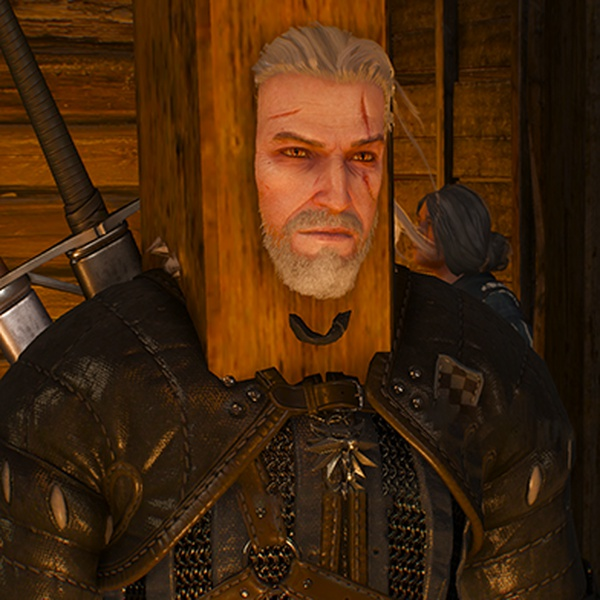

In [132]:
img

In [133]:
x = np.array(img) # преобразование из PIL в numpy array

In [134]:
x.dtype

dtype('uint8')

In [135]:
x = np.array([1, 80, 250], dtype=np.uint8)
x

array([  1,  80, 250], dtype=uint8)

In [136]:
x * 2

array([  2, 160, 244], dtype=uint8)

In [137]:
x - np.array([100, 100, 100], dtype=np.uint8)

array([157, 236, 150], dtype=uint8)

In [138]:
x = np.array(img, np.float64) # преобразование из PIL в numpy array

In [139]:
x.dtype

dtype('float64')

In [140]:
x.shape

(600, 600, 3)

In [141]:
U, s, Vt = np.linalg.svd(x[:,:,0], full_matrices=False) # разложение SVD
U.shape, s.shape, Vt.shape

((600, 600), (600,), (600, 600))

In [142]:
y = U.dot(np.diag(s).dot(Vt))

In [143]:
y.shape

(600, 600)

In [144]:
np.allclose(x[:,:,0], y)

True

In [145]:
r = 10
y_r = U[:, :r].dot(np.diag(s[:r]).dot(Vt[:r]))

In [146]:
np.linalg.norm(x[:,:,0] - y_r)

9588.645174210282

In [147]:
def compress_image(singular_value):
    x_new = x.copy()
    for i in range(3):
        U, s, Vt = np.linalg.svd(x[:,:,i], full_matrices=False) # разложение SVD
        x_new[:, :, i] = U[:, :singular_value].dot(np.diag(s[:singular_value]).dot(Vt[:singular_value]))

    x_new = np.clip(x_new, 0, 255)
    x_new = np.asarray(x_new, dtype=np.uint8)
    compressed_image = Image.fromarray(x_new)
    compressed_image.save(f'compressed_image_{singular_value}.png')
    return compressed_image

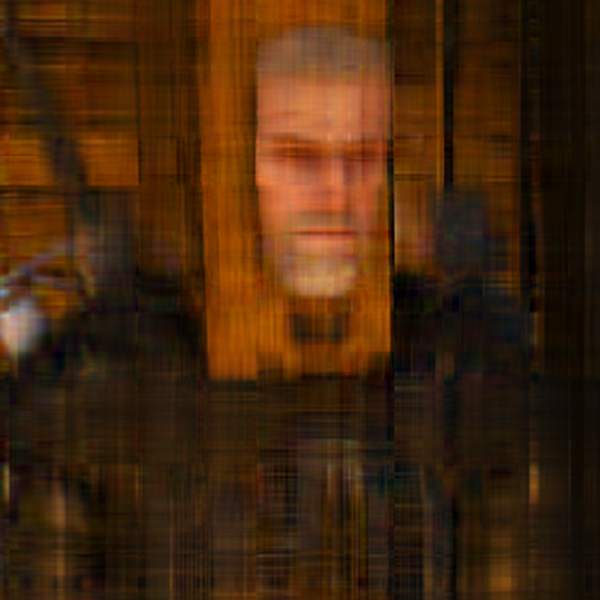

In [148]:
compress_image(10)

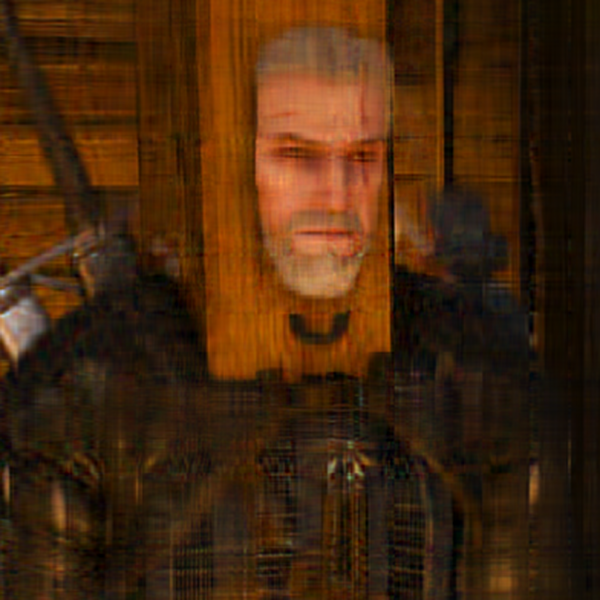

In [149]:
compress_image(20)

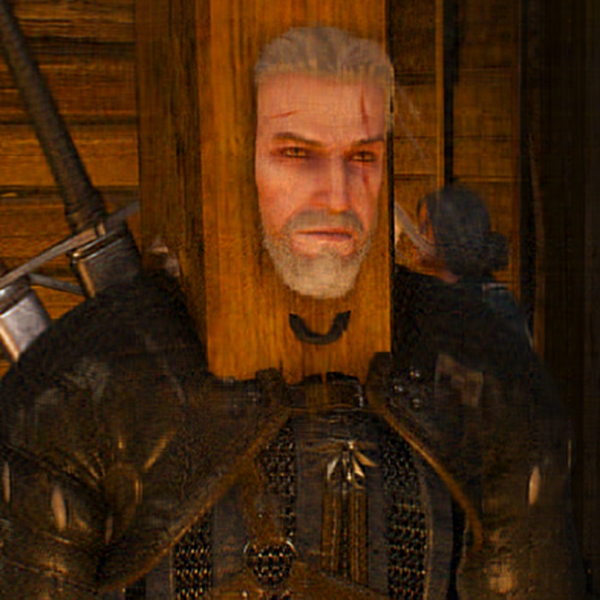

In [150]:
compress_image(50)

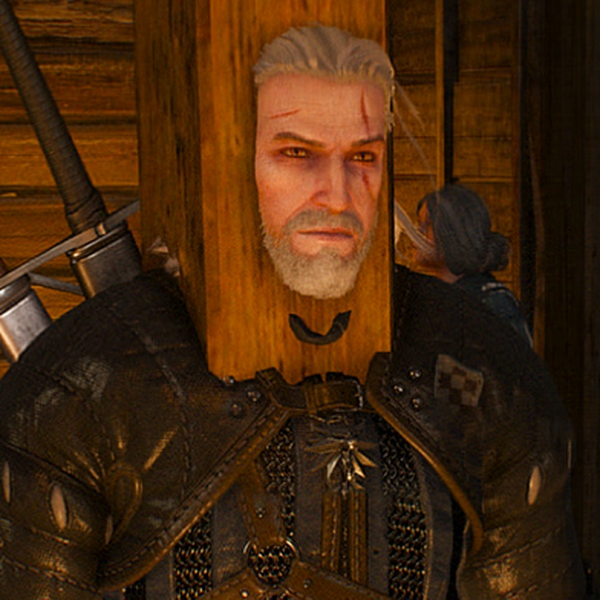

In [151]:
compress_image(100)

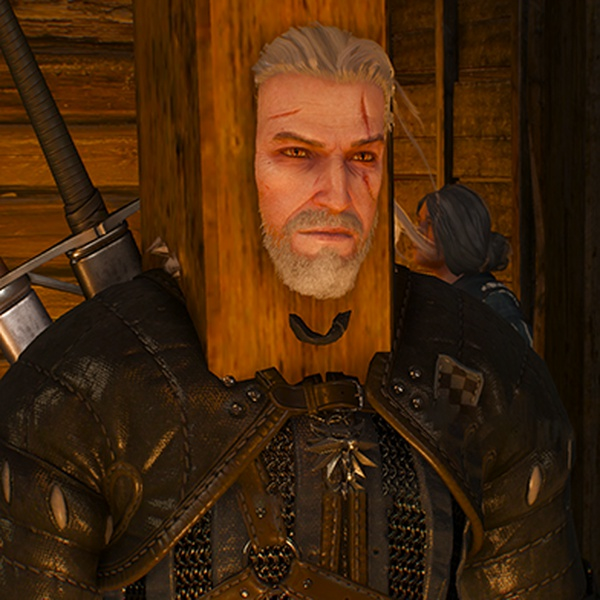

In [152]:
compress_image(1000)

In [153]:
files = os.listdir('.')

# Проверяем наличие оригинала
if image_path not in files:
    raise FileNotFoundError(f'Файл {image_path} не найден в текущем каталоге')

# Размер оригинала
original_size = os.path.getsize(image_path) / 1024  # КБ

data = []

# Добавляем оригинал
data.append({
    'степень сжатия': 'оригинал',
    'размер (КБ)': round(original_size, 2),
    'процент сжатия относительно оригинала': 100.0
})

# Регулярка для compressed_image_<r>.png
pattern = re.compile(r'compressed_image_(\d+)\.png')

for filename in files:
    match = pattern.match(filename)
    if match:
        r = int(match.group(1))
        size_kb = os.path.getsize(filename) / 1024
        percent = (size_kb / original_size) * 100
        
        data.append({
            'степень сжатия': r,
            'размер (КБ)': round(size_kb, 2),
            'процент сжатия относительно оригинала': round(percent, 2)
        })

# Создаём DataFrame и сортируем
df = pd.DataFrame(data)
df = df.sort_values(by='степень сжатия', key=lambda x: x.map(lambda v: float('inf') if v == 'оригинал' else v))
df


,степень сжатия,размер (КБ),процент сжатия относительно оригинала
1,10,325.33,56.20
4,20,376.44,65.03
5,50,450.27,77.78
2,100,494.84,85.48
3,1000,503.92,87.05
0,оригинал,578.87,100.00
